In [1]:
import numpy as np
import scipy
import qutip
import matplotlib.pyplot as plt
import math
from Eulerian import *
from Algo2_helper import *
from Algo2_negative_time import *

In [2]:
# --- System size ---
site = 4

# --- Pauli matrices ---
X = np.matrix([[0, 1], [1, 0]], dtype=complex)
Y = np.matrix([[0, -1j], [1j, 0]], dtype=complex)
Z = np.matrix([[1, 0], [0, -1]], dtype=complex)
I = np.matrix(np.eye(2, dtype=complex))

# --- Construct static Hamiltonian H0 ---
HXX = HYY = HZZ = 0
for i in range(site - 1):
    HXX += XX_pair(site, i, i + 1)
    HZZ += ZZ_pair(site, i, i + 1)
    HYY += -XX_pair(site, i, i + 1).dot(ZZ_pair(site, i, i + 1))
H0 = HXX + HYY + HZZ

# --- Local Pauli operators ---
X1, Y1, Z1 = np.kron(X, np.kron(I, np.kron(I, I))), \
              np.kron(Y, np.kron(I, np.kron(I, I))), \
              np.kron(Z, np.kron(I, np.kron(I, I)))
X2, Y2, Z2 = np.kron(I, np.kron(X, np.kron(I, I))), \
              np.kron(I, np.kron(Y, np.kron(I, I))), \
              np.kron(I, np.kron(Z, np.kron(I, I)))
X3, Y3, Z3 = np.kron(I, np.kron(I, np.kron(X, I))), \
              np.kron(I, np.kron(I, np.kron(Y, I))), \
              np.kron(I, np.kron(I, np.kron(Z, I)))
X4, Y4, Z4 = np.kron(I, np.kron(I, np.kron(I, X))), \
              np.kron(I, np.kron(I, np.kron(I, Y))), \
              np.kron(I, np.kron(I, np.kron(I, Z)))

# --- Collective controls on sites 2 and 4 ---
X24 = X2 + X4
Y24 = Y2 + Y4
Z24 = Z2 + Z4

# ================================================================
#  Finite-width pulse implementations
# ================================================================
def X24p(tp): return scipy.linalg.expm(-1j * (np.pi/2 * X24 + H0 * tp))
def Y24p(tp): return scipy.linalg.expm(-1j * (np.pi/2 * Y24 + H0 * tp))

def X24n(tp): return scipy.linalg.expm(-1j * (-np.pi/2 * X24 + H0 * tp))
def Y24n(tp): return scipy.linalg.expm(-1j * (-np.pi/2 * Y24 + H0 * tp))

# ================================================================
#  Eulerian pulse lists (forward and reverse)
# ================================================================
def P_list(c, tp):
    """Forward Eulerian pulse sequence on (2,4)."""
    return [X24p(c * tp), Y24p(c * tp), X24p(c * tp), Y24p(c * tp),
            Y24p(c * tp), X24p(c * tp), Y24p(c * tp), X24p(c * tp)]

def P_rev_list(c, tp):
    """Reverse-time version of Eulerian pulse sequence."""
    return [X24n(c * tp), Y24n(c * tp), X24n(c * tp), Y24n(c * tp),
            Y24n(c * tp), X24n(c * tp), Y24n(c * tp), X24n(c * tp)]

In [3]:
# ================================================================
#  Target Hamiltonian and Group Sequence Setup
# ================================================================

# --- Coupled operators acting on (2,4) ---
X24_f = np.kron(I, np.kron(X, np.kron(I, X)))
Y24_f = np.kron(I, np.kron(Y, np.kron(I, Y)))
Z24_f = np.kron(I, np.kron(Z, np.kron(I, Z)))
I24_f = np.kron(I, np.kron(I, np.kron(I, I)))

# --- Random coupling strengths ---
Jx = np.random.uniform(0, 1)
Jy = np.random.uniform(0, 1)
Jz = np.random.uniform(0, 1)


Jx,Jy,Jz = (0.9824481792382058, 0.55445774573614856, 0.8429639111767378) #chosen in the paper

# --- Target Hamiltonian: weighted combination of HXX, HYY, HZZ ---
H_targ = Jx * HXX + Jy * HYY + Jz * HZZ
Js = Jx + Jy + Jz

# --- Eulerian group (2,4) for Algorithm 2 sequence ---
group = [I24_f, X24_f, Z24_f, Y24_f, I24_f, Y24_f, Z24_f, X24_f]

# --- Corresponding effective time segments ---
tau_klist = (1 / 4) * np.array([Js, Jx, Jz, Jy, Js, Jy, Jz, Jx])

# --- Free evolution operator under drift H0 ---
def free(tau, tp):
    """Free evolution under static drift Hamiltonian H0 for duration τ."""
    return scipy.linalg.expm(-1j * tau * H0)


In [4]:
# ================================================================
#  Algorithm 2 Sequences (Eulerian–Symmetrized Multi-Product)
# ================================================================

def S1(T, tp):
    """First-order Eulerian sequence S_1(T)."""
    c = 1
    P_klist = P_list(c, tp)
    U = np.eye(2**site, dtype=complex)
    for i, P_k in enumerate(P_klist):
        tau_k = tau_klist[i]
        U = (P_k @ free(tau_k * T, tp)) @ U
    return U


def S1_rev(T, tp):
    """Time-reversed version of S_1(T)."""
    c = 1
    P_rev_klist = P_rev_list(c, tp)
    U = np.eye(2**site, dtype=complex)
    for i in range(len(P_rev_klist)):
        P_rev_k = P_rev_klist[len(P_rev_klist) - i - 1]
        tau_k = tau_klist[len(P_rev_klist) - i - 1]
        U = (free(tau_k * T, tp) @ P_rev_k) @ U
    return U


def S2(T, tp):
    """Second-order symmetrized sequence S_2(T) = S_1(T/2) S_1^{rev}(T/2)."""
    U_forw = S1(T / 2, tp)
    U_back = S1_rev(T / 2, tp)
    return U_forw @ U_back


def S4(T, tp):
    """Fourth-order Trotter sequence S_4(T) (translation step used, no negative-evolution implementation)."""
    u2 = 1 / (4 - 4 ** (1 / 3))

    def S2_M(T, tp):
        c = -(1 - 4 * u2) / u2
        p_list = P_list(c, tp)
        p_rev_list = P_rev_list(c, tp)

        def p_phi(j):
            U = np.eye(2**site, dtype=complex)
            for i in range(j - 1, -1, -1):
                U = U @ p_list[i]
            for i in range(len(p_list) - 1, j, -1):
                U = U @ p_list[i]
            return U

        def p_rev_phi(j):
            U = np.eye(2**site, dtype=complex)
            for i in range(j + 1, len(p_list)):
                U = U @ p_rev_list[i]
            for i in range(0, j):
                U = U @ p_rev_list[i]
            return U

        U_forw = np.eye(2**site, dtype=complex)
        for i in range(len(p_list)):
            tau_k = tau_klist[i]
            U_forw = (p_rev_phi(i) @ free(tau_k * T / 2, tp)) @ U_forw

        U_back = np.eye(2**site, dtype=complex)
        for i in range(len(p_list)):
            tau_k = tau_klist[len(p_list) - i - 1]
            U_back = (free(tau_k * T / 2, tp) @ p_phi(len(p_list) - i - 1)) @ U_back

        return U_forw @ U_back

    return (
        S2(u2 * T, tp)
        @ S2(u2 * T, tp)
        @ S2_M((1 - 4 * u2) * T, tp)
        @ S2(u2 * T, tp)
        @ S2(u2 * T, tp)
    )


def S4_raw(T, tp):
    """Fourth-order Trotter sequence 𝒮₄(T) (raw finite-width pulses (translation step is not used), \
                                                no negative-evolution implementation)."""
    u2 = 1 / (4 - 4 ** (1 / 3))

    return (
        S2(u2 * T, tp)
        @ S2(u2 * T, tp)
        @ S2((1 - 4 * u2) * T, tp)
        @ S2(u2 * T, tp)
        @ S2(u2 * T, tp)
    )


In [5]:
def S4_refocus(T, tp):
    """Algorithm 2, 4th-order with refocused middle block only."""
    u2 = 1 / (4 - 4 ** (1 / 3))

    def S2_refocused(T, tp):
        """Refocused middle second-order block (for negative-time part)."""
        c = -(1 - 4 * u2) / u2
        p_list = P_list(c, tp)
        p_rev_list = P_rev_list(c, tp)

        def p_phi(j):
            U = np.eye(2**site, dtype=complex)
            for i in range(j - 1, -1, -1):
                U = U @ p_list[i]
            for i in range(len(p_list) - 1, j, -1):
                U = U @ p_list[i]
            return U

        def p_rev_phi(j):
            U = np.eye(2**site, dtype=complex)
            for i in range(j + 1, len(p_list)):
                U = U @ p_rev_list[i]
            for i in range(0, j):
                U = U @ p_rev_list[i]
            return U

        U_forw = np.eye(2**site, dtype=complex)
        for i in range(len(p_list)):
            tau_k = tau_klist[i]
            U_forw = (p_rev_phi(i) @ refocus_4_project(-tau_k * T / 2, tp)) @ U_forw

        U_back = np.eye(2**site, dtype=complex)
        for i in range(len(p_list)):
            tau_k = tau_klist[len(p_list) - i - 1]
            U_back = (refocus_4_project(-tau_k * T / 2, tp) @ p_phi(len(p_list) - i - 1)) @ U_back

        return U_forw @ U_back

    return (
        S2(u2 * T, tp)
        @ S2(u2 * T, tp)
        @ S2_refocused((1 - 4 * u2) * T, tp)
        @ S2(u2 * T, tp)
        @ S2(u2 * T, tp)
    )


In [6]:
# ================================================================
#  Algorithm 2: Heisenberg simulation scaling for multiple tp
# ================================================================

Tlist = np.logspace(-1.4, 0, 20)
tp_values = [1e-4, 5e-5, 1e-5]

# Storage for all results
results = {}

for tp in tp_values:
    print(f"\n=== Running simulation for tp = {tp:.1e} ===")
    
    e1, e2, e4, e4_raw, e4_refocus = [], [], [], [], []
    
    for T in Tlist:
        print(f"  Simulation time T : {T:.3e}")
        U_id = scipy.linalg.expm(-1j * H_targ * T)
        
        e1.append(gate_fidelity(U_id, S1(T, tp), site))
        e2.append(gate_fidelity(U_id, S2(T, tp), site))
        e4.append(gate_fidelity(U_id, S4(T, tp), site))
        e4_raw.append(gate_fidelity(U_id, S4_raw(T, tp), site))
        e4_refocus.append(gate_fidelity(U_id, S4_refocus(T, tp), site))
    
    # Save results for this tp
    results[tp] = {
        'Tlist': Tlist,
        'e1': e1,
        'e2': e2,
        'e4': e4,
        'e4_raw': e4_raw,
        'e4_refocus': e4_refocus
    }




=== Running simulation for tp = 1.0e-04 ===
  Simulation time T : 3.981e-02
  Simulation time T : 4.717e-02
  Simulation time T : 5.589e-02
  Simulation time T : 6.623e-02
  Simulation time T : 7.848e-02
  Simulation time T : 9.299e-02
  Simulation time T : 1.102e-01
  Simulation time T : 1.306e-01
  Simulation time T : 1.547e-01
  Simulation time T : 1.833e-01
  Simulation time T : 2.172e-01
  Simulation time T : 2.574e-01
  Simulation time T : 3.049e-01
  Simulation time T : 3.613e-01
  Simulation time T : 4.281e-01
  Simulation time T : 5.073e-01
  Simulation time T : 6.011e-01
  Simulation time T : 7.122e-01
  Simulation time T : 8.439e-01
  Simulation time T : 1.000e+00

=== Running simulation for tp = 5.0e-05 ===
  Simulation time T : 3.981e-02
  Simulation time T : 4.717e-02
  Simulation time T : 5.589e-02
  Simulation time T : 6.623e-02
  Simulation time T : 7.848e-02
  Simulation time T : 9.299e-02
  Simulation time T : 1.102e-01
  Simulation time T : 1.306e-01
  Simulation t

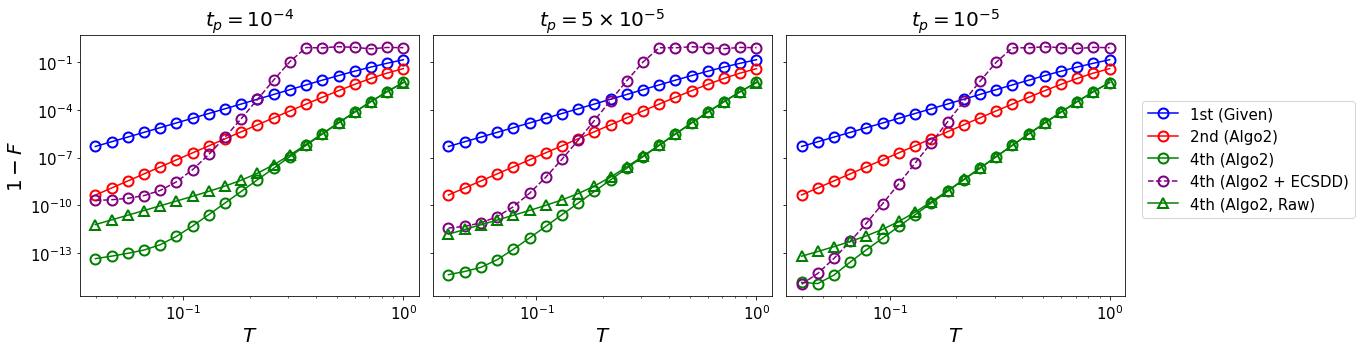

In [37]:
fig, axs = plt.subplots(1, len(tp_values), figsize=(19, 5), sharey=True)
ms, mw = 10, 2

for i, tp in enumerate(tp_values):
    ax = axs[i]
    Tlist = results[tp]['Tlist']
    e1 = results[tp]['e1']
    e2 = results[tp]['e2']
    e4 = results[tp]['e4']
    e4_raw = results[tp]['e4_raw']
    e4_refocus = results[tp]['e4_refocus']
    
    # --- DCG / Refocused sequences ---
    ax.plot(Tlist, e1, 'o-', color='blue',  ms=ms,
            markerfacecolor="None", markeredgewidth=mw, label='1st (Given)')
    ax.plot(Tlist, e2, 'o-', color='red',   ms=ms,
            markerfacecolor="None", markeredgewidth=mw, label='2nd (Algo2)')
    ax.plot(Tlist, e4, 'o-', color='green', ms=ms,
            markerfacecolor="None", markeredgewidth=mw, label='4th (Algo2)')
    ax.plot(Tlist, e4_refocus, 'o--', color='purple', ms=ms,
            markerfacecolor="None", markeredgewidth=mw, label='4th (Algo2 + ECSDD)')
    
    # --- Raw 4th-order ---
    ax.plot(Tlist, e4_raw, '^-', color='green', ms=ms,
            markerfacecolor="None", markeredgewidth=mw, label='4th (Algo2, Raw)')
    
    # --- Axes & labels ---
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$T$', fontsize=20)
    if i == 0:
        ax.set_ylabel(r'$1 - F$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)

# --- Legend & layout ---
axs[0].set_title(fr'$t_p = 10^{{{int(np.log10(tp_values[0]))}}}$', fontsize=20)
axs[1].set_title(fr'$t_p = 5 \times 10^{{{int(np.log10(tp_values[2]))}}}$', fontsize=20)
axs[2].set_title(fr'$t_p = 10^{{{int(np.log10(tp_values[2]))}}}$', fontsize=20)

axs[2].legend(ncol=1, loc=(1.05, 0.3), fontsize=15)
plt.tight_layout()
#plt.savefig("Algo2_Numerics.png", dpi=300, bbox_inches='tight')
plt.show()

# Multi-product formulas

In [8]:
# ================================================================
#  Algorithm 2: Base sequence definitions (finite-width)
# ================================================================

def free(tau, tp):
    """Free evolution under drift Hamiltonian H0."""
    return scipy.linalg.expm(-1j * tau * H0)


def S1(T, tp, c):
    """
    First-order sequence block.
    """
    P_klist = P_list(c, tp)
    U = np.eye(2 ** site, dtype=complex)
    for i, P_k in enumerate(P_klist):
        tau_k = tau_klist[i]
        U = (P_k @ free(tau_k * T, tp)) @ U
    return U


def S1_rev(T, tp, c):
    """
    Time-reversed version of S₁(T).
    """
    P_rev_klist = P_rev_list(c, tp)
    U = np.eye(2 ** site, dtype=complex)
    for i in range(len(P_rev_klist)):
        P_rev_k = P_rev_klist[len(P_rev_klist) - i - 1]
        tau_k = tau_klist[len(P_rev_klist) - i - 1]
        U = (free(tau_k * T, tp) @ P_rev_k) @ U
    return U


def S2(T, tp, c):
    """
    Second-order (time-symmetric) sequence:
    """
    U_forw = S1(T / 2, tp, c)
    U_back = S1_rev(T / 2, tp, c)
    return U_forw @ U_back

In [9]:
# ================================================================
#  Multi-Product Formula (MPF) for Algorithm 2 (finite-width)
# ================================================================

klist = [1, 2]               # Subdivision factors
clist = [-1/3, 4/3]          # Childs 4th-order MPF coefficients

rho0 = np.array([[1, 0], [0, 0]], dtype=complex)
rho_init = np.kron(rho0, np.kron(rho0, np.kron(rho0, rho0)))  # |0000><0000|

tp = 1e-5
Tlist = np.logspace(-2, 0, 20)  # total simulation times

def rho_MPF(rho0, klist, clist, T, tp):
    rho_out = np.zeros_like(rho0, dtype=complex)
    for k_j, c_j in zip(klist, clist):
        S2kj = np.linalg.matrix_power(S2(T / k_j, tp, c= max(klist)/k_j), k_j) #c-stretching is important!
        rho_out += c_j * (S2kj @ rho0 @ S2kj.conj().T)
    return rho_out


# ================================================================
#  Simulation loop
# ================================================================

e_T1_MPF, e_T2_MPF, e_T4_MPF = [], [], []

for T in Tlist:
    U_id = scipy.linalg.expm(-1j * H_targ * T)
    rho_id = U_id @ rho_init @ U_id.conj().T

    rho1 = S1(T, tp, c=1) @ rho_init @ S1(T, tp, c=1).conj().T
    rho2 = S2(T, tp, c=1) @ rho_init @ S2(T, tp, c=1).conj().T
    rho4 = rho_MPF(rho_init, klist, clist, T, tp)

    e_T1_MPF.append(trace_distance(rho_id, rho1, 4))
    e_T2_MPF.append(trace_distance(rho_id, rho2, 4))
    e_T4_MPF.append(trace_distance(rho_id, rho4, 4))

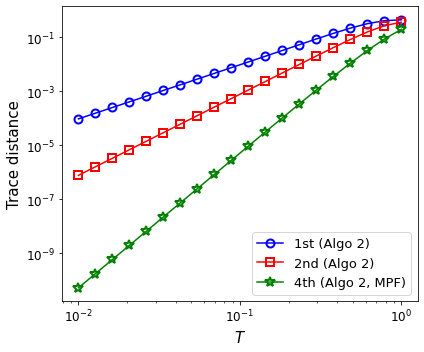

In [13]:
# ================================================================
#  Figure: Algorithm 2 (finite-width) + Multi-Product Formula (MPF)
# ================================================================

fig, ax = plt.subplots(figsize=(6, 5))
ms=8
ax.plot(Tlist, e_T1_MPF, 'o-', color='blue',
        markeredgecolor='blue', markerfacecolor='none',  ms=ms, markeredgewidth=2,
        label=r'1st (Algo 2)')
ax.plot(Tlist, e_T2_MPF, 's-', color='red', 
        markeredgecolor='red', markerfacecolor='none',  ms=ms, markeredgewidth=2,
        label=r'2nd (Algo 2)')
ax.plot(Tlist, e_T4_MPF, '*-', color='green', 
        markeredgecolor='green', markerfacecolor='none',  ms=ms+2, markeredgewidth=2,
        label=r'4th (Algo 2, MPF)')

ax.set_xlabel(r'$T$', fontsize=15)
ax.set_ylabel(r'Trace distance', fontsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

ax.legend(fontsize=13, loc='lower right')
#ax.grid(alpha=0.25, which='both', linestyle='--', linewidth=0.7)

fig.tight_layout()
#plt.savefig("Algo2_MPF", dpi = 200)
plt.show()